In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
#from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
from PIL import Image 
import torchvision.transforms as transforms 
from matplotlib import pyplot as plt
from os import listdir
from os import makedirs
from os.path import join
from os.path import exists
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def visualize(x):
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
     
    # Creating plot
    ax.scatter3D(x[:,0], x[:,1], x[:,2], color = "blue")
    plt.title("Point Set")
     
    # show plot
    plt.show()

In [3]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, datadir):
        super(DatasetFromFolder, self).__init__()

        datadir1 = join(datadir,'00')
        filenames1 = [join(datadir1, x) for x in listdir(datadir1)]
        
        datadir2 = join(datadir,'01')
        filenames2 = [join(datadir2, x) for x in listdir(datadir2)]

        datadir3 = join(datadir,'02')
        filenames3 = [join(datadir3, x) for x in listdir(datadir3)]

        self.filenames = filenames1 + filenames2 + filenames3

    def __getitem__(self,index):
        name = self.filenames[index]
        input = torch.from_numpy(np.loadtxt(name).transpose(1,0)).type(torch.FloatTensor)

        target = torch.zeros([1], dtype=torch.long)
        if name.find("/00/") >= 0:
            target[0] = 0 #cylinder
        elif name.find("/01/") >=0:
            target[0] = 1 #rectangle
        elif name.find("/02/") >=0:
            target[0] = 2 #torus
        else :
            print("bug")
        
        return input, target

    def __len__(self):
        return len(self.filenames)


In [4]:
#transform
class MyTNet(nn.Module):
    def __init__(self, dim=3):
        super(MyTNet, self).__init__()
        self.dim = dim
        self.seq1 = nn.Sequential(
            nn.Conv1d(self.dim, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Conv1d(64, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Conv1d(128, 1024, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(1024),
            nn.ReLU(True)
        )
        self.seq2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, self.dim * self.dim)
        )


    def forward(self,x):
        y = self.seq1(x)
        x = torch.max(self.seq1(x), 2, keepdim = False)[0] #max gives (max_value, index)
        x = self.seq2(x)
        #adding to the identity matrix
        myidentity = torch.from_numpy(np.eye(self.dim, dtype=np.float32)).view(1, self.dim*self.dim).repeat(x.size()[0],1)
        if x.is_cuda:
            myidentity = myidentity.cuda()
        x = x + myidentity
        x = x.view(-1, self.dim, self.dim)

        return x

In [5]:
#PointNet
class MyPointNet(nn.Module):
    def __init__(self, dim=3, dimfeat=64, num_class = 3):
        super(MyPointNet, self).__init__()
        self.Tnet1 = MyTNet(dim)
        self.conv1 = nn.Sequential(
            nn.Conv1d(dim, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(True)
        )
        self.Tnet2 = MyTNet(dimfeat)
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU(True)
        )
        self.lin = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256,num_class),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,x):
        matrice = self.Tnet1(x)
        #print("matrice : ", matrice.shape, ", x : ", x.shape)
        x = x.transpose(1, 2)  # Change la forme en [32, 2048, 3]
        x = torch.bmm(x, matrice)  # Produit matriciel, rÃ©sultat : [32, 2048, 3]
        x = x.transpose(1, 2)        
        x = self.conv1(x)
        x = self.Tnet2(x)
        x = torch.max(self.conv2(x), 2, keepdim = False)[0]
        x = self.lin(x)
        return x

In [6]:
myptnet = MyPointNet()

if not exists('weights/mypointnet.pt'):
    myptnet.to(device)
    
    num_epochs = 10
    num_w = 4  
    batch_s = 32
    
    #Loss and optimizer
    optimizer = optim.SGD(myptnet.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.NLLLoss()
    
    #loading data
    trainset = DatasetFromFolder("data/train")
    trainloader = DataLoader(trainset, batch_size=batch_s, shuffle=True)

    # validationset = DatasetFromFolder("data/train")
    # validationloader = DataLoader(validationset, batch_size=batch_s, shuffle=True)

    losslog = []
    
    #train
    for epoch in range(num_epochs):
        for inputs, targets in trainloader:
            targets = targets.view(-1)  
            y = myptnet(inputs)
            loss = criterion(y, targets)
            loss.backward()
            losslog.append(loss) #.item())
            optimizer.step()
        if (epoch)%10 == 0 :
            print(f"{epoch} Epoch - training loss:{losslog[-1]:.4f}")
        
        # #validation
        # acc = 0.
        # # On lit toutes les données de validation
        # for x,t in validation_loader:
        #     y = model(x)
        #     acc += torch.argmax(y,1) == torch.argmax(t,1)    
    torch.save(myptnet.state_dict(), 'weights/mypointnet.pt')
else :
    #read the saved model
    myptnet.load_state_dict(torch.load('weights/mypointnet.pt'))
    myptnet.eval()

bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug


In [10]:
print(f'losslog[0->5]: {[f"{loss.item():.4f}" for loss in losslog[::5]]}')

losslog[0->5]: ['1.2512', '0.5989', '0.0229', '0.0002', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']


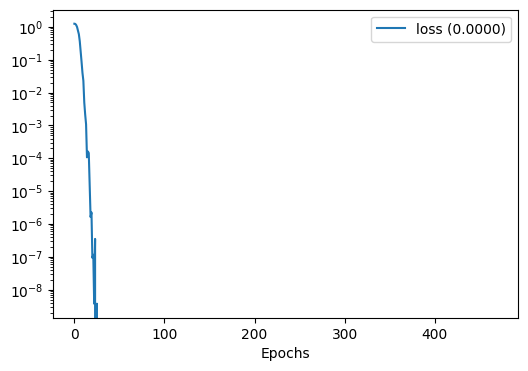

In [11]:
# display loss
plt.figure(figsize=(6,4))
plt.yscale('log')
#plt.plot(losslog, label = 'loss ({:.4f})'.format(losslog[-1]))
plt.plot([loss.item() for loss in losslog], label = 'loss ({:.4f})'.format(losslog[-1].item()))
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

bug


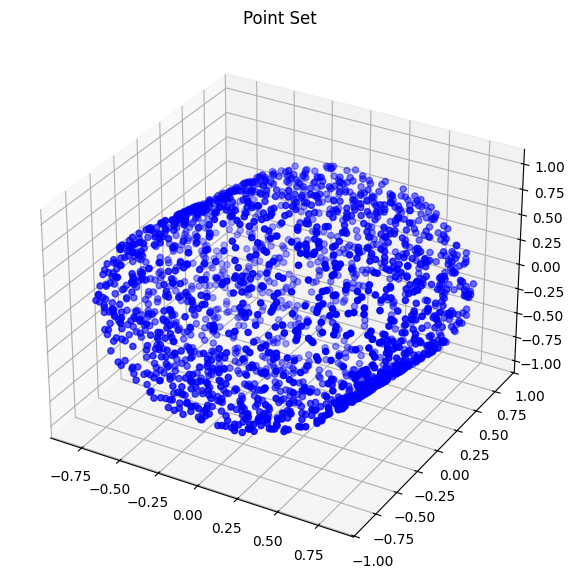

output :  tensor([[   0.0000, -914.6920, -798.8177]], grad_fn=<LogSoftmaxBackward0>)


In [33]:
testset = DatasetFromFolder("data/test")
testloader = DataLoader(testset, num_workers=0, batch_size=1, shuffle=False)

# Set the model to evaluation mode
myptnet.eval()

#show the 3D output generated by the network taking the first element of the testset
#input,target = testset.__getitem__(45)
input = testloader.__iter__().__next__()[0]
#print(f'input : {input} \n target : {target}')
visualize(input.detach().numpy())

output = myptnet(input)#testset.__getitem__(0)[0].unsqueeze(0))
print("output : ", output)
#visualize(output.detach().numpy())


bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug


C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


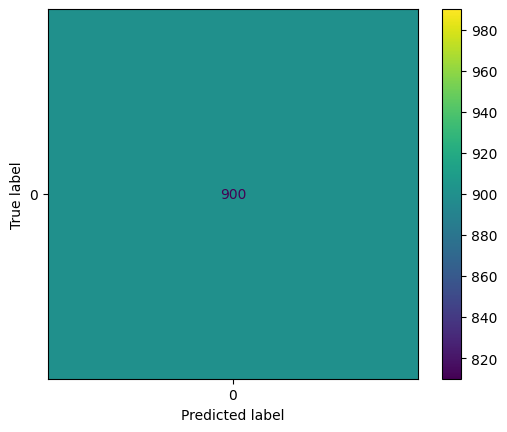

In [37]:
gtlabels = []
predlabels = []
#test
acc = 0.
for input,target in testloader : 
    y = myptnet.forward(input)
    acc += torch.argmax(y,1) == torch.argmax(target,1)
    gtlabels.append(target[0].item())
    predlabels.append(torch.argmax(y,1).item())   
print(f'accuracy : {acc/len(testset)}')  

cm = confusion_matrix(gtlabels, predlabels)
ConfusionMatrixDisplay(cm).plot()

### PointNet and TNet

**PointNet** is a neural network architecture designed specifically for processing and analyzing point clouds. Point clouds are sets of data points in 3D space, typically representing the external surface of objects or scenes. PointNet was introduced by Charles R. Qi et al. in their 2017 paper "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation."

### Why PointNet Uses TNet

**TNet** (Transformation Network) is a crucial component of the PointNet architecture. It is used to learn spatial transformations of point clouds, making the network invariant to geometric transformations such as rotation and translation. This is important because the order and orientation of points in a point cloud are arbitrary and should not affect the network's output.

#### Key Reasons for Using TNet

1. **Permutation Invariance**:
   - Point clouds do not have a fixed order of points. TNet helps ensure that the network's output is invariant to the order of input points.

2. **Geometric Transformation Invariance**:
   - Point clouds can be captured from different angles and positions. TNet learns to align the point clouds to a canonical pose, making the network robust to rotations and translations.

3. **Feature Alignment**:
   - By aligning the point clouds, TNet helps the network extract more meaningful and consistent features, improving the overall performance of the model.

### How TNet Works

TNet is inspired by Spatial Transformer Networks (STNs) and consists of a small neural network that predicts a transformation matrix. This matrix is then applied to the input point cloud to align it to a canonical pose.

#### TNet Architecture

1. **Input Layer**:
   - Takes the input point cloud, which is a set of 3D points.

2. **Shared MLPs**:
   - A series of shared Multi-Layer Perceptrons (MLPs) that process each point independently to extract point-wise features.

3. **Max Pooling**:
   - A max pooling layer that aggregates the point-wise features into a global feature vector.

4. **Fully Connected Layers**:
   - Fully connected layers that process the global feature vector to predict the transformation matrix.

5. **Transformation Matrix**:
   - The output is a transformation matrix (e.g., a 3x3 or 6x6 matrix) that is applied to the input point cloud.

### PointNet for Point Cloud Classification

PointNet uses TNet as a base to ensure that the input point cloud is aligned and invariant to geometric transformations. The overall architecture of PointNet for point cloud classification can be summarized as follows:

1. **Input Transformation**:
   - The input point cloud is passed through the first TNet to predict a 3x3 transformation matrix, which is applied to the input points.

2. **Feature Extraction**:
   - The transformed points are processed by shared MLPs to extract point-wise features.

3. **Feature Transformation**:
   - The point-wise features are passed through a second TNet to predict a 64x64 transformation matrix, which is applied to the features.

4. **Global Feature Aggregation**:
   - The transformed features are aggregated using max pooling to obtain a global feature vector representing the entire point cloud.

5. **Classification**:
   - The global feature vector is passed through fully connected layers to predict the class of the point cloud.



### Summary

- **TNet**:
  - Ensures permutation and geometric transformation invariance.
  - Aligns point clouds to a canonical pose, improving feature extraction.

- **PointNet**:
  - Uses TNet to preprocess point clouds.
  - Extracts both global and local features using shared MLPs and max pooling.
  - Aggregates features to classify point clouds.